In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv("../../store.csv",header=0,index_col=0)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.shape)

df.head()

(2470, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2014-04-10,12937.4,13055.6,12881.2,12949.4,0
2014-04-11,12822.2,12934.9,12778.0,12840.2,0
2014-04-15,12830.5,12831.6,12537.7,12579.9,0
2014-04-16,12557.4,12727.0,12514.8,12563.2,0
2014-04-17,12564.5,12819.1,12514.8,12787.2,0


In [3]:
df_week = df.resample('w').mean()
df_week = df_week[['Close']]
df_week.head()

,Close
Date,
2014-04-13,12894.800000
2014-04-20,12643.433333
2014-04-27,13025.550000
2014-05-04,12922.450000
2014-05-11,13114.560000


In [13]:
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
# df_week['weekly_ret'] = 100*df_week['Close'].pct_change().dropna()
df_week.head()

,Close,weekly_ret
Date,,
2014-04-13,12894.800000,NaN
2014-04-20,12643.433333,-0.019686
2014-04-27,13025.550000,0.029775
2014-05-04,12922.450000,-0.007947
2014-05-11,13114.560000,0.014757


In [14]:
# drop null rows
df_week.dropna(inplace=True)

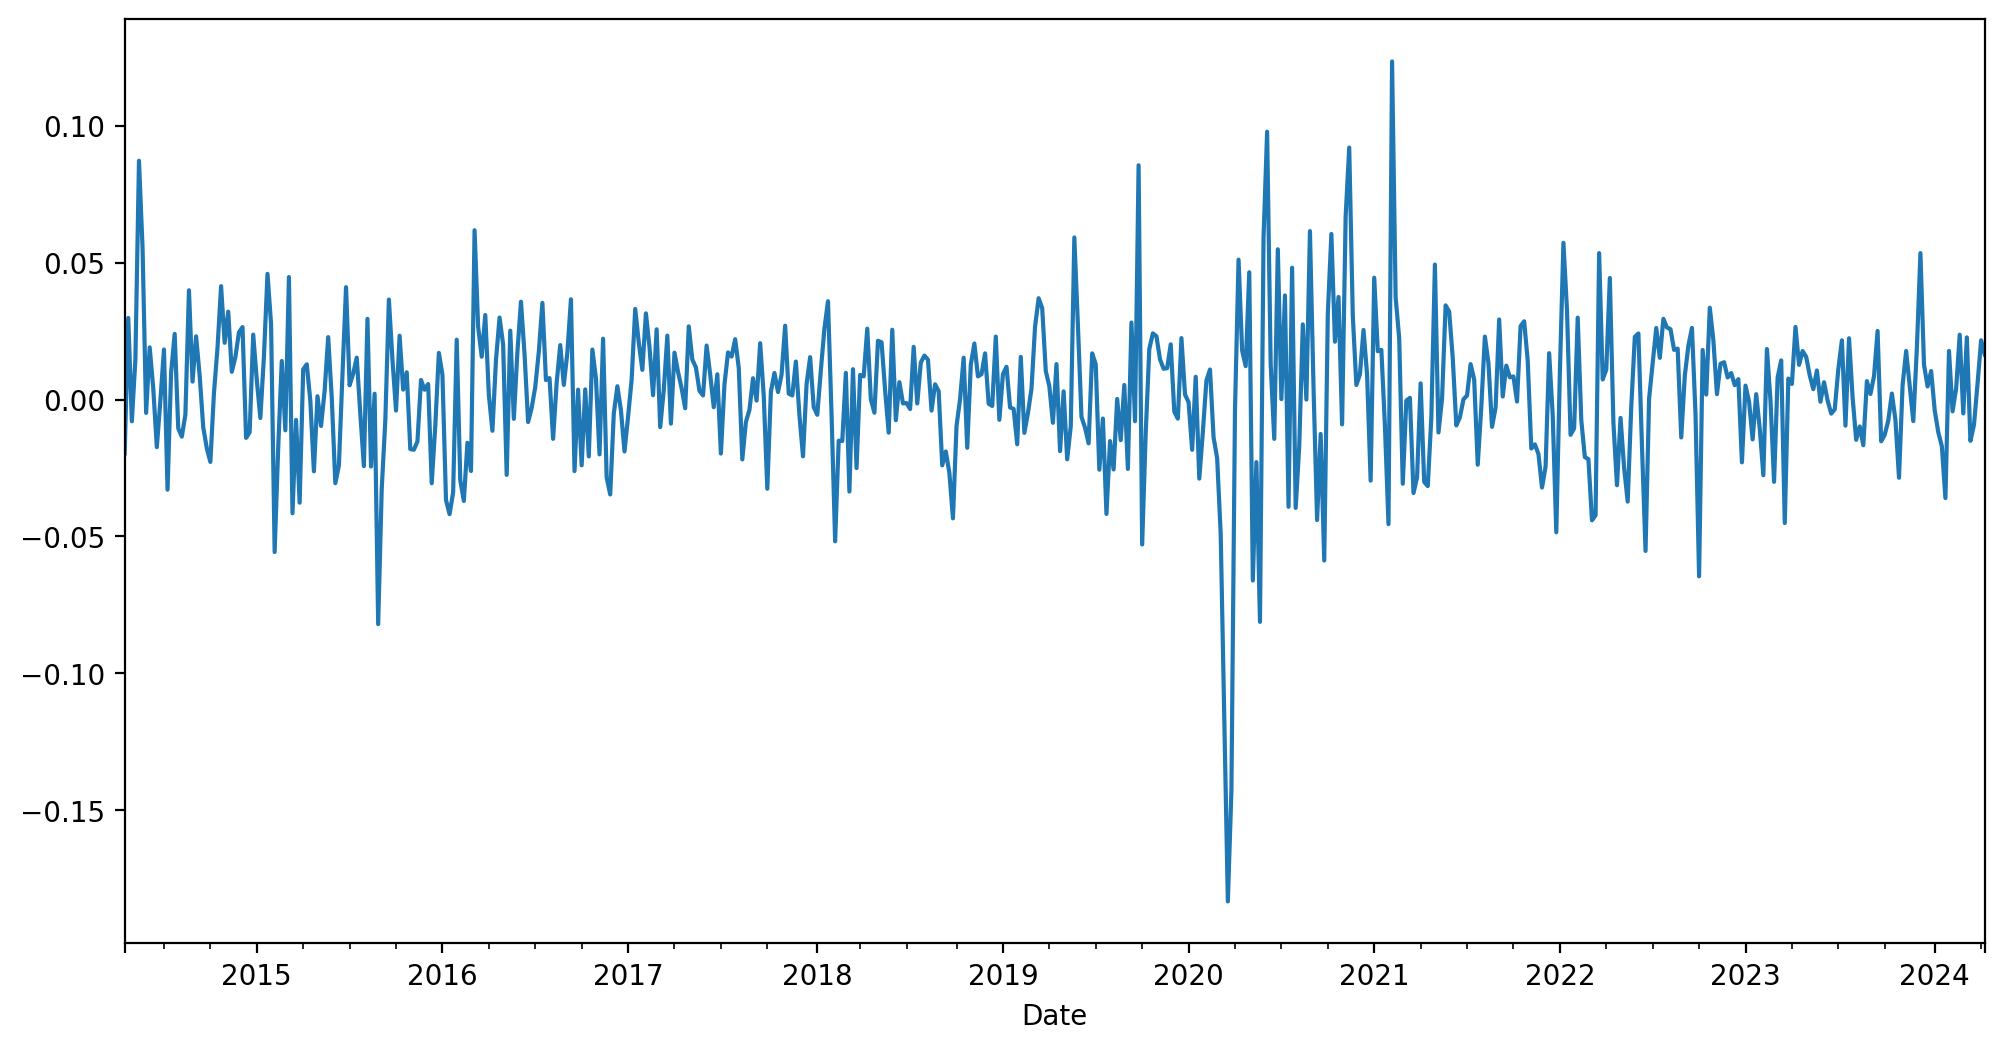

In [15]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [16]:
udiff = df_week.drop(['Close'], axis=1)
udiff.head()

,weekly_ret
Date,
2014-04-20,-0.019686
2014-04-27,0.029775
2014-05-04,-0.007947
2014-05-11,0.014757
2014-05-18,0.087195


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [18]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

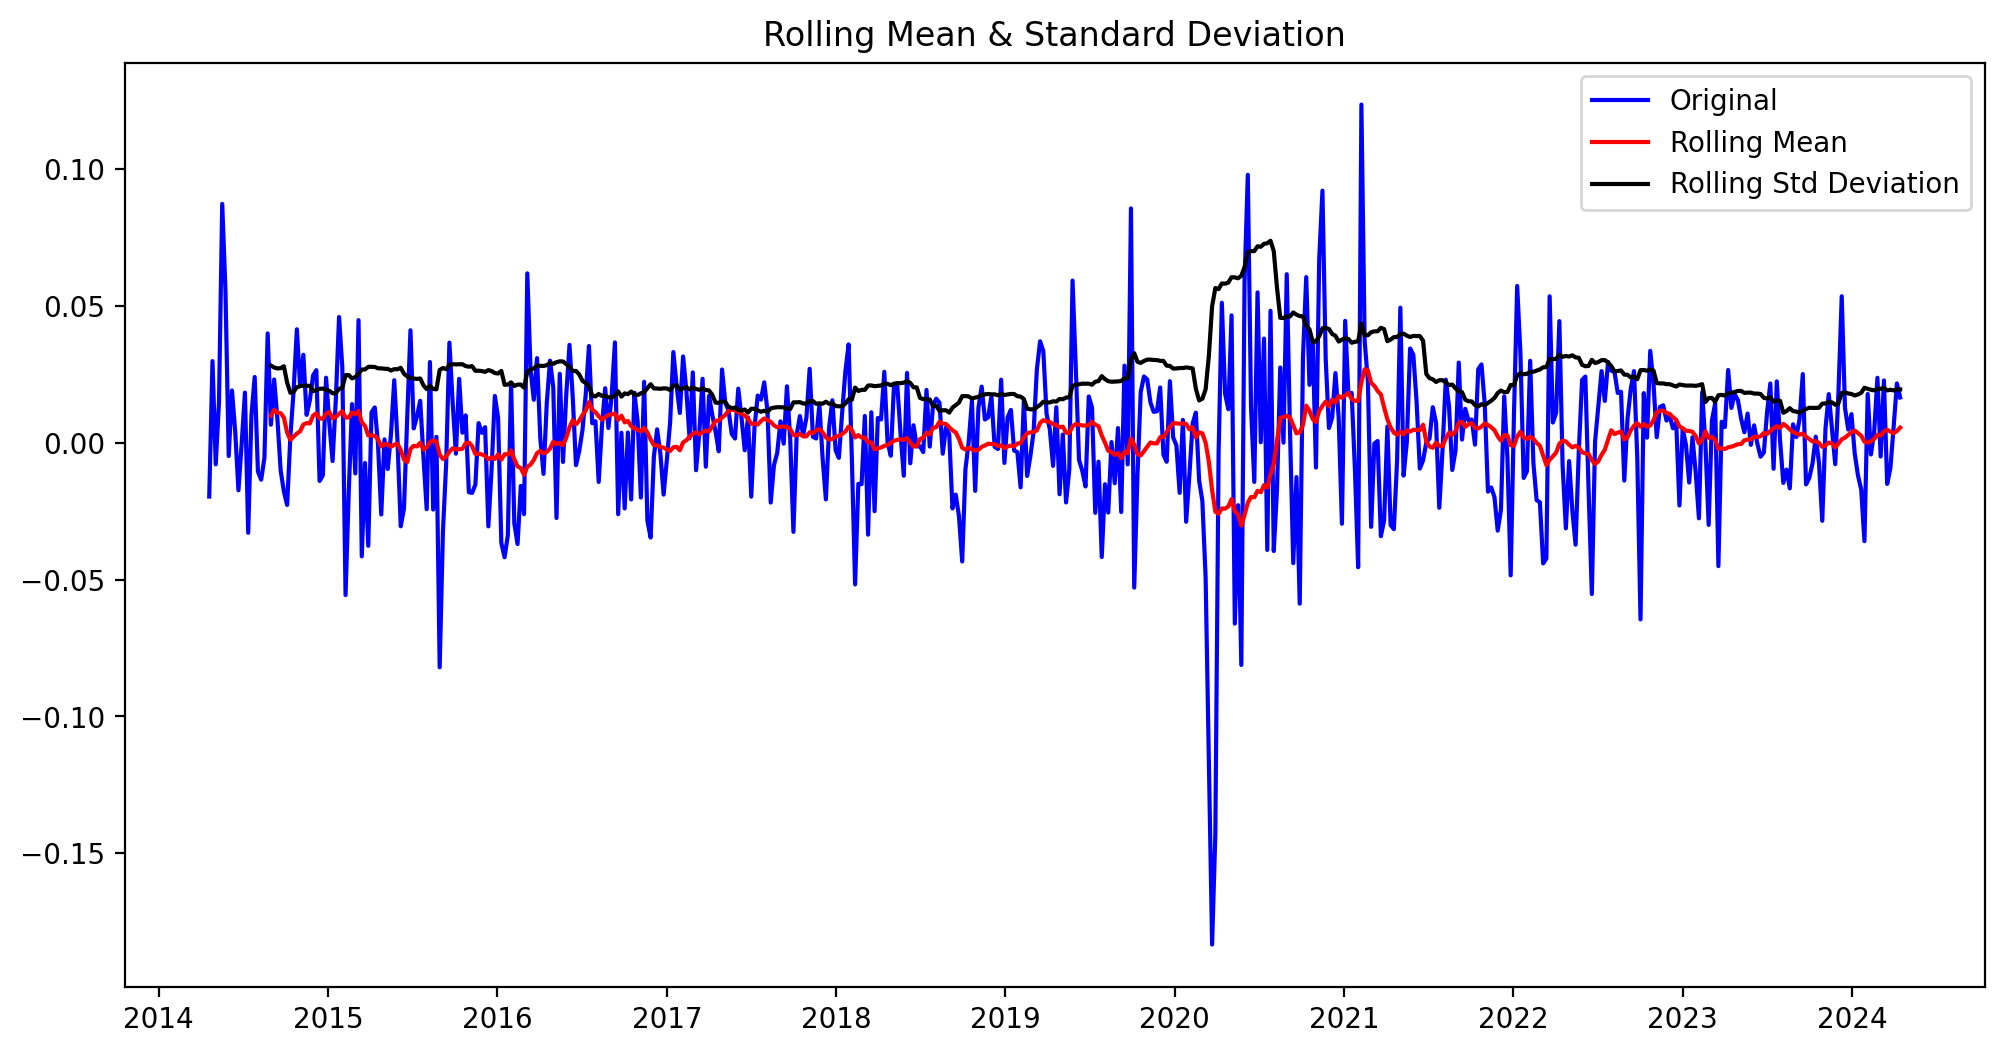

In [19]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [20]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.739739e+01
p-value                        4.969428e-30
#Lags Used                     0.000000e+00
Number of Observations Used    5.210000e+02
Critical Value (1%)           -3.442964e+00
Critical Value (5%)           -2.867103e+00
Critical Value (10%)          -2.569733e+00
dtype: float64

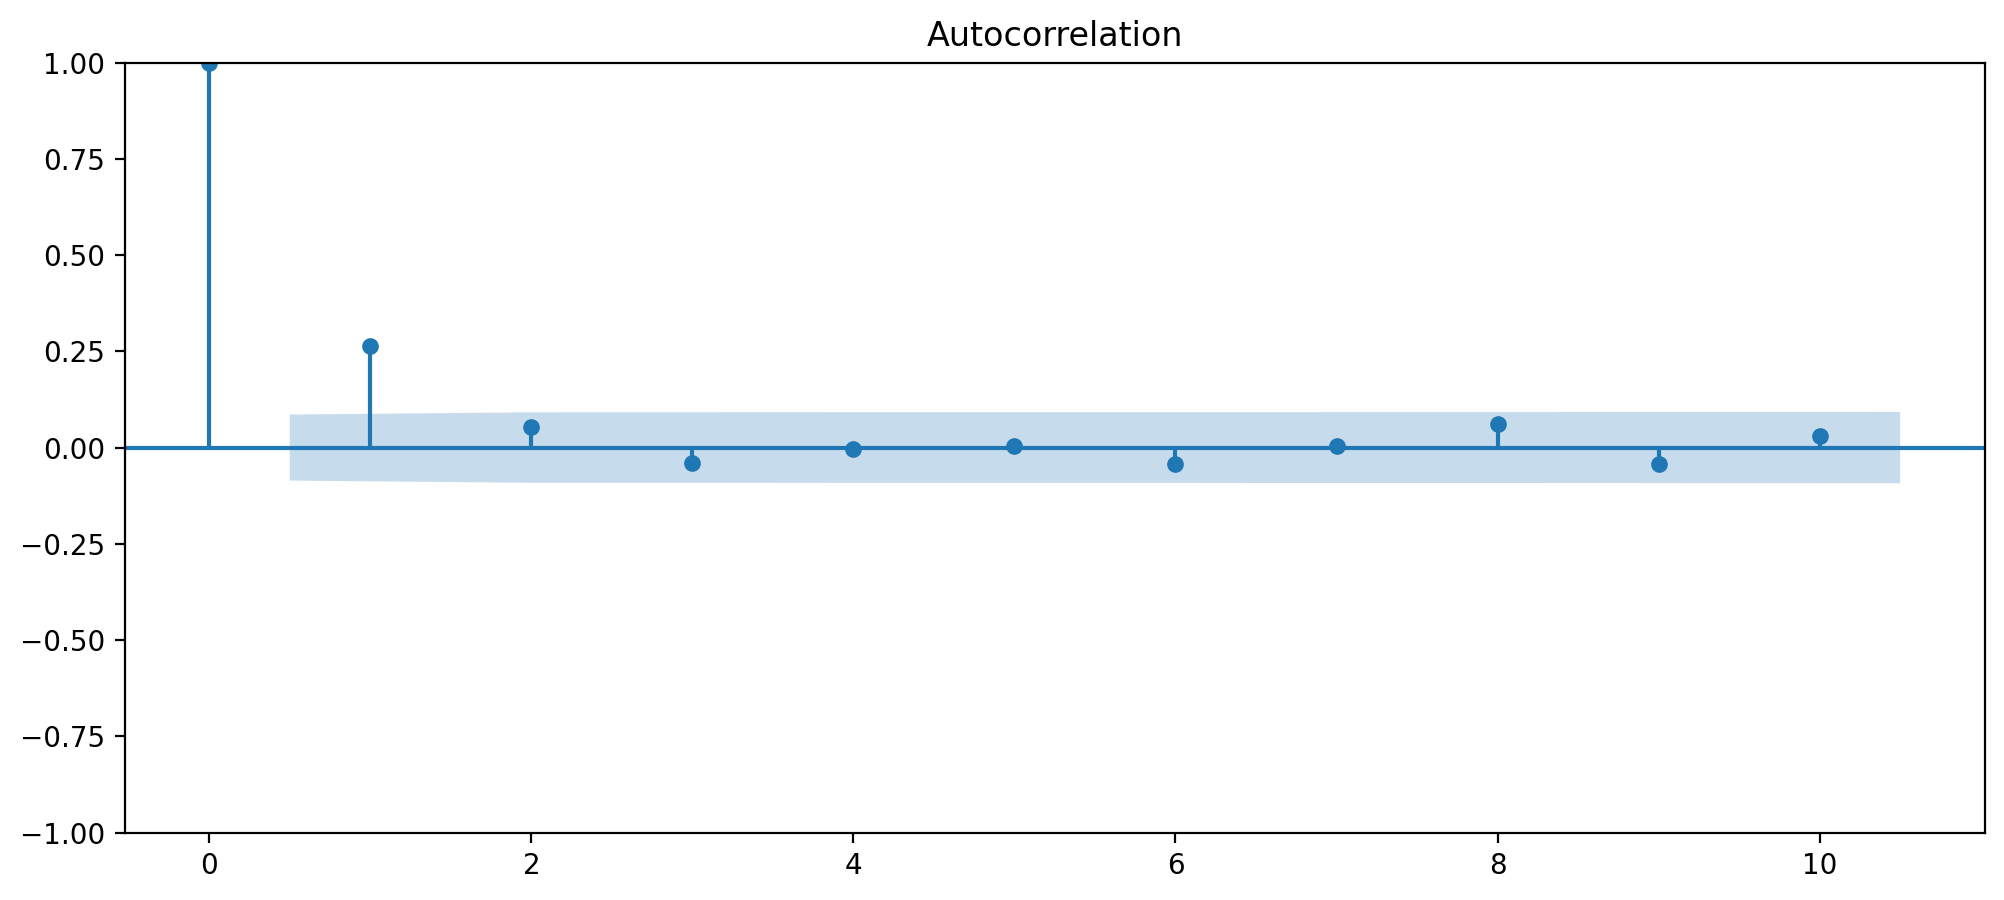

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

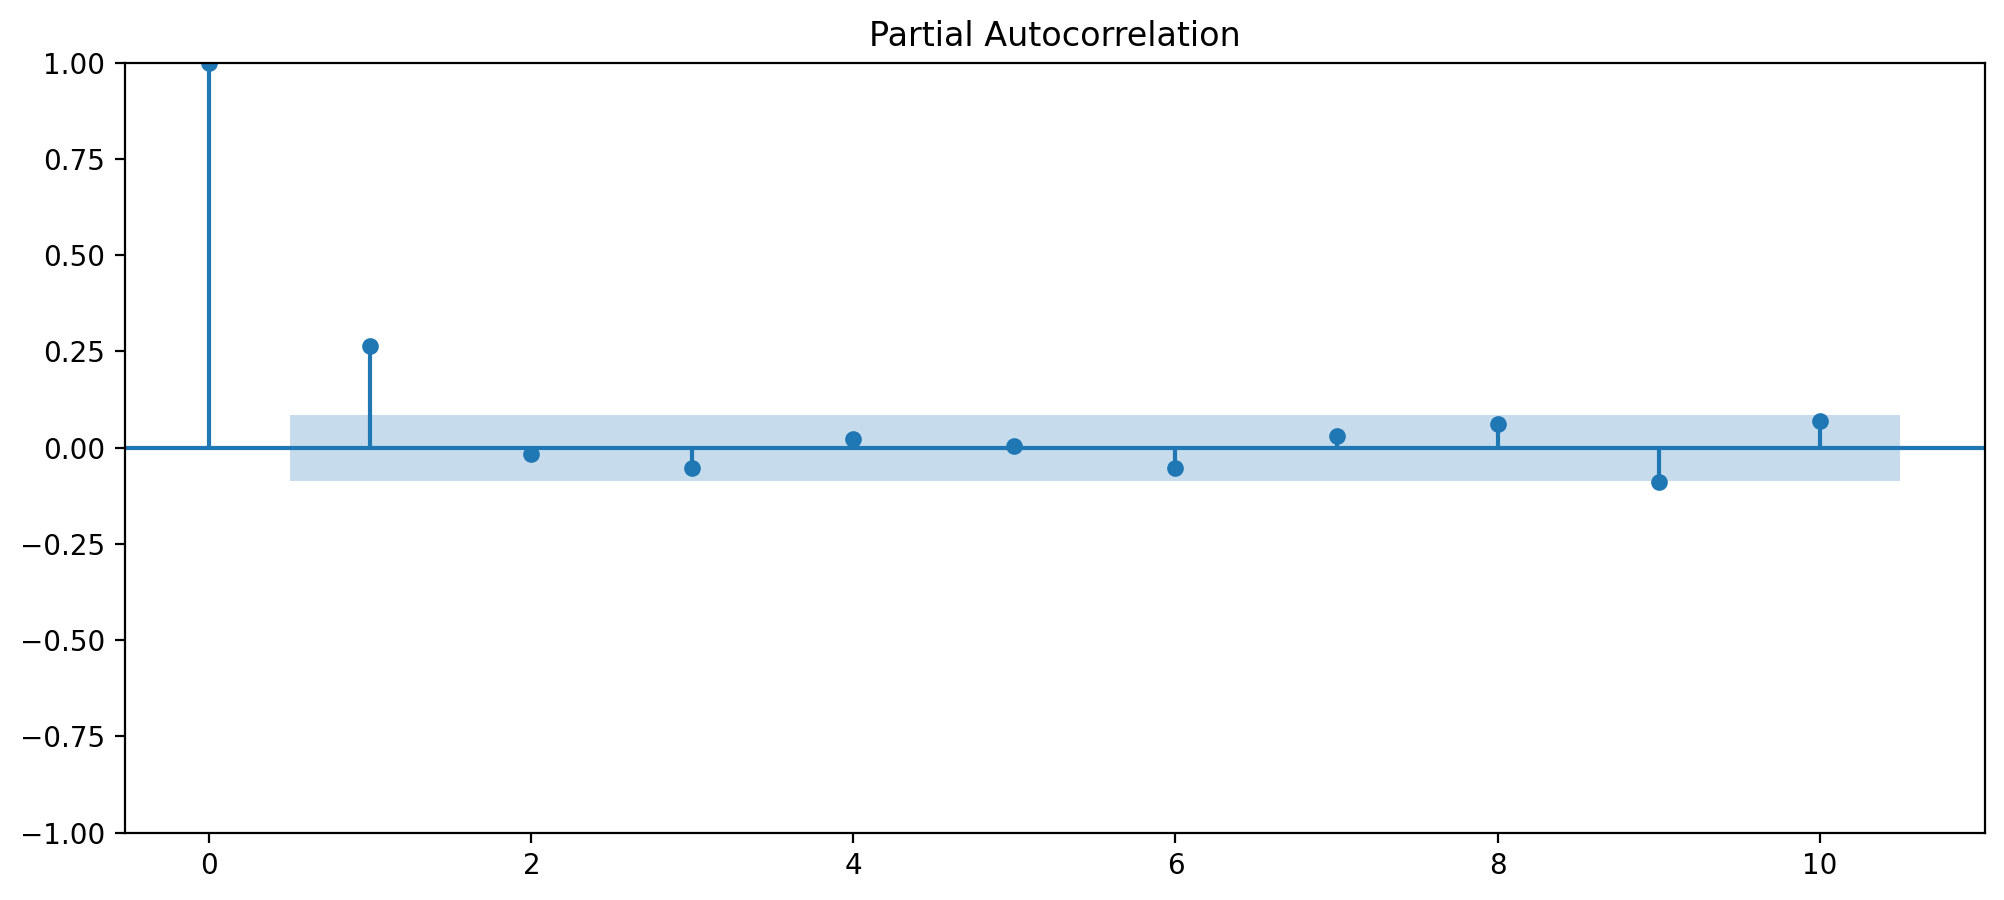

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

In [23]:
from statsmodels.tsa.arima.model import ARIMA
ar1 = ARIMA(udiff.values, order = (1, 0,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1164.372
Date:                Wed, 01 May 2024   AIC                          -2320.744
Time:                        00:13:07   BIC                          -2303.713
Sample:                             0   HQIC                         -2314.073
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.535      0.125      -0.001       0.006
ar.L1          0.2101      0.127      1.651      0.099      -0.039       0.459
ma.L1          0.0611      0.135      0.452      0.651      -0.204       0.326
sigma2         0.0007   2.45e-05     27.605      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               496.40
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.31
Prob(H) (two-sided):                  0.71   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

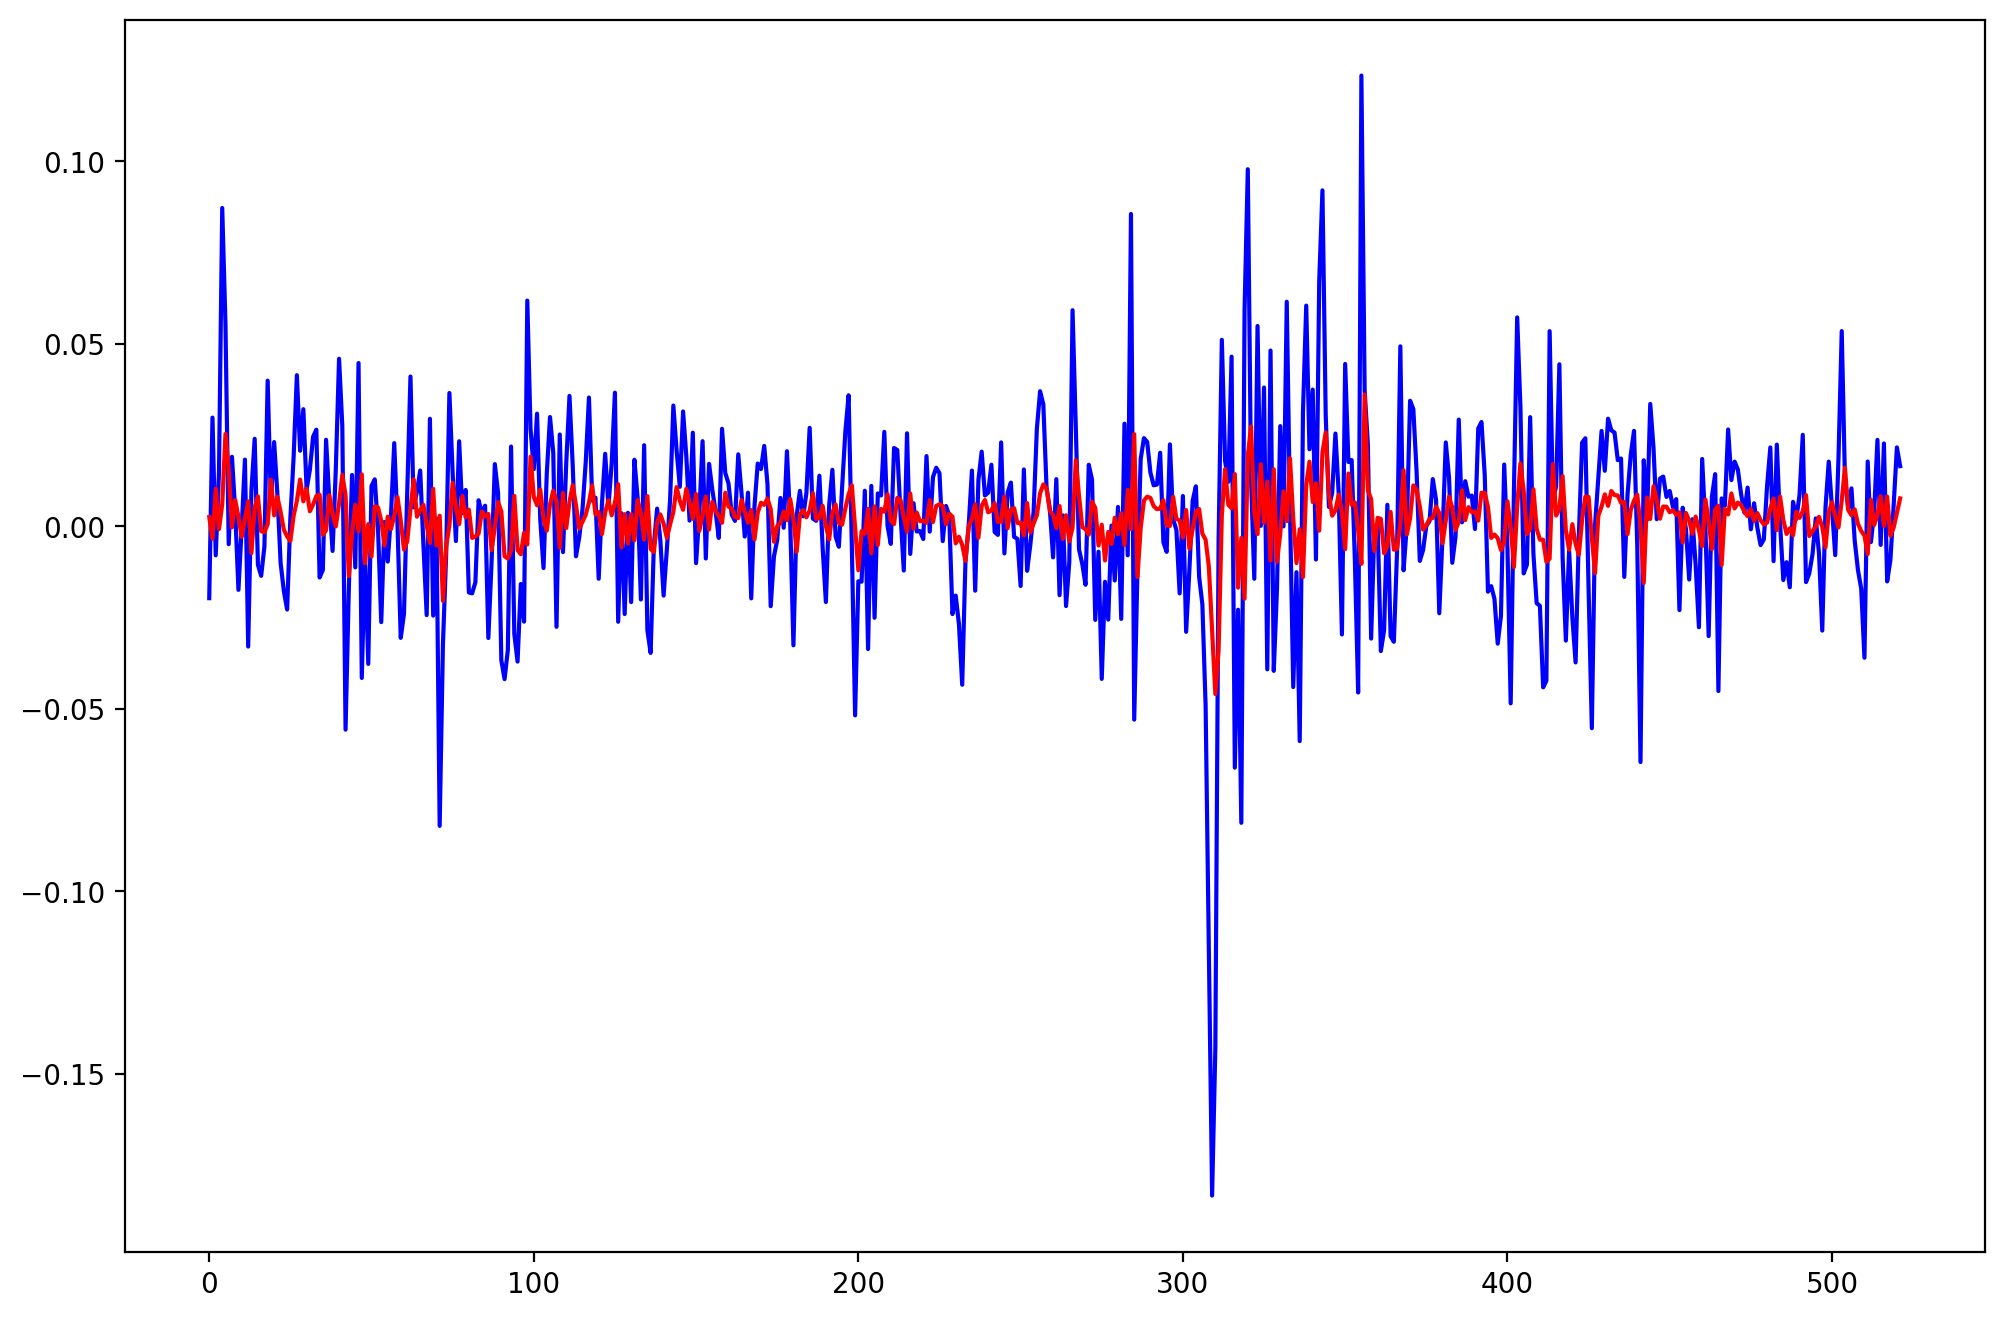

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()